# An Exploration of Credit Card Default Risk Factors

In [1]:
import numpy as np
import pandas as pd
import tables
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, accuracy_score
import statistics
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder

from sklearn import tree
from IPython.display import Image
import pydotplus
import graphviz
%matplotlib inline

Let's begin by importing our data.

In [2]:
credit = pd.read_csv('default_of_creditcard_clients.csv')

credit.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


Below we can see that we don't have any null values to deal with so we can move on to cleaning up our column names and further exploring the data.

In [3]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
ID                            30000 non-null int64
LIMIT_BAL                     30000 non-null int64
SEX                           30000 non-null int64
EDUCATION                     30000 non-null int64
MARRIAGE                      30000 non-null int64
AGE                           30000 non-null int64
PAY_0                         30000 non-null int64
PAY_2                         30000 non-null int64
PAY_3                         30000 non-null int64
PAY_4                         30000 non-null int64
PAY_5                         30000 non-null int64
PAY_6                         30000 non-null int64
BILL_AMT1                     30000 non-null int64
BILL_AMT2                     30000 non-null int64
BILL_AMT3                     30000 non-null int64
BILL_AMT4                     30000 non-null int64
BILL_AMT5                     30000 non-null int64
BILL_AMT6               

In [4]:
credit.rename(columns={'default payment next month': 'default_target'}, inplace=True)
credit.columns=credit.columns.str.lower()

In [5]:
credit.describe()

,id,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default_target
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


At first glance it seems that all our data is numerical and that our data has already been coded. However, when we look into our data further, we can see that some of our columns need dummies created. For instance, our 'education' column really shows if someone has a high school diploma, bachelor's, or master's degree. It would be important to have each of these separated into its own column so that we can determine whether or not someone with a bachelor's is more likely to default for example.

In [6]:
dummy_df = pd.DataFrame(data=credit, columns=['pay_0', 'pay_1', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 
                                              'education', 'marriage'], dtype=object)

categorical_cols = [col_name for col_name in dummy_df.dtypes[dummy_df.dtypes.values == 'object'].index]

dummy = pd.get_dummies(dummy_df[categorical_cols], drop_first=True)


credit = pd.concat([credit, dummy], axis=1)
credit.head()

,id,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,...,pay_6_8,education_1,education_2,education_3,education_4,education_5,education_6,marriage_1,marriage_2,marriage_3
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,1,0,0,0,0,1,0,0
1,2,120000,2,2,2,26,-1,2,0,0,...,0,0,1,0,0,0,0,0,1,0
2,3,90000,2,2,2,34,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
3,4,50000,2,2,1,37,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,0,0,1,0,0,0,0,1,0,0


We'll drop the original columns since their dummies have now been created, their presence is now redundant.

In [7]:
credit.drop(['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'education', 'marriage'], axis=1)

,id,limit_bal,sex,age,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,...,pay_6_8,education_1,education_2,education_3,education_4,education_5,education_6,marriage_1,marriage_2,marriage_3
0,1,20000,2,24,3913,3102,689,0,0,0,...,0,0,1,0,0,0,0,1,0,0
1,2,120000,2,26,2682,1725,2682,3272,3455,3261,...,0,0,1,0,0,0,0,0,1,0
2,3,90000,2,34,29239,14027,13559,14331,14948,15549,...,0,0,1,0,0,0,0,0,1,0
3,4,50000,2,37,46990,48233,49291,28314,28959,29547,...,0,0,1,0,0,0,0,1,0,0
4,5,50000,1,57,8617,5670,35835,20940,19146,19131,...,0,0,1,0,0,0,0,1,0,0
5,6,50000,1,37,64400,57069,57608,19394,19619,20024,...,0,1,0,0,0,0,0,0,1,0
6,7,500000,1,29,367965,412023,445007,542653,483003,473944,...,0,1,0,0,0,0,0,0,1,0
7,8,100000,2,23,11876,380,601,221,-159,567,...,0,0,1,0,0,0,0,0,1,0
8,9,140000,2,28,11285,14096,12108,12211,11793,3719,...,0,0,0,1,0,0,0,1,0,0
9,10,20000,1,35,0,0,0,0,13007,13912,...,0,0,0,1,0,0,0,0,1,0


Now let's run our correlation table again so that we can see which variables are most significant.

In [8]:
credit.corr()['default_target'].sort_values(ascending=False)

default_target    1.000000
pay_0_2           0.353881
pay_0             0.324794
pay_2_2           0.313191
pay_3_2           0.270885
pay_2             0.263551
pay_4_2           0.249674
pay_5_2           0.239308
pay_3             0.235253
pay_6_2           0.219068
pay_4             0.216614
pay_5             0.204149
pay_6             0.186866
pay_0_3           0.134656
pay_0_1           0.106690
pay_2_3           0.099842
pay_6_3           0.079513
pay_5_3           0.076993
pay_3_3           0.076549
pay_4_3           0.072986
pay_4_7           0.064301
pay_5_7           0.064301
pay_6_7           0.057111
pay_0_4           0.056219
pay_4_4           0.051532
pay_5_4           0.049273
pay_3_4           0.043438
pay_3_7           0.042926
pay_6_4           0.040097
pay_2_4           0.039351
                    ...   
bill_amt4        -0.010156
id               -0.013952
bill_amt3        -0.014076
bill_amt2        -0.014193
bill_amt1        -0.019644
marriage         -0.024339
e

This is a little complicated to read, but right away we can tell that the most significant variables relate to payment history. According to the background information regarding our dataset, our columns with the dummy of 2 would indicate the person in question is two months late on their payment. The first number indicates what month the payment is due. So, we can see that most often, people who are two months late are likely to default. We can also see that those who pay on time, are most likely to not default.

## Linear Regression Modeling

In [9]:
# Y is the target variable
Y = credit['default_target']
# X is the feature set 
X = credit[['pay_0_2', 'pay_2_2', 'pay_3_2', 'pay_4_2', 'pay_0_0']]

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, stratify=credit.default_target, random_state=1)

We will run an OLS model just to see what kind of response we get from our model.

In [10]:
X = sm.add_constant(X)

OLS_results = sm.OLS(Y, X).fit()

OLS_results.summary()

/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         default_target   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.176
Method:                 Least Squares   F-statistic:                     1282.
Date:                Mon, 23 Sep 2019   Prob (F-statistic):               0.00
Time:                        12:24:30   Log-Likelihood:                -13283.
No. Observations:               30000   AIC:                         2.658e+04
Df Residuals:                   29994   BIC:                         2.663e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1817      0.004     49.734      0.000       0.175       0.189
pay_0_2        0.3395      0.009     38.893      0.000       0.322       0.357
pay_2_2        0.1331      0.008     15.815      0.000       0.117       0.150
pay_3_2        0.0974      0.009     11.386      0.000       0.081       0.114
pay_4_2        0.1140      0.009     13.292      0.000       0.097       0.131
pay_0_0       -0.0662      0.005    -13.852      0.000      -0.076      -0.057
==============================================================================
Omnibus:                     5194.642   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8312.518
Skew:                           1.238   Prob(JB):                         0.00
Kurtosis:                       3.719   Cond. No.                         5.68
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Our R-Squared is not fantastic. Let's try some Linear Regression models to see if there's a better fit.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

scaler = StandardScaler()
X_std = scaler.fit_transform(X)

regr_cv = RidgeCV(alphas=[0.1, 1.0, 5, 10.0, 100, 500, 1000, 2000, 10**4, 10**6])
model_cv = regr_cv.fit(X_std, Y)
model_cv.alpha_


100.0

In [12]:
ridgeregr = Ridge(alpha=100) 
ridgeregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = ridgeregr.predict(X_train)
y_preds_test = ridgeregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(ridgeregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridgeregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


R-squared of the model on the training set is: 0.1745288222813952
-----Test set statistics-----
R-squared of the model on the test set is: 0.1812379083531882
Mean absolute error of the prediction is: 0.2835304444299523
Mean squared error of the prediction is: 0.1405759699784219
Root mean squared error of the prediction is: 0.374934620938667
Mean absolute percentage error of the prediction is: inf


In [13]:
 print(cross_val_score(ridgeregr, X, Y, cv=10)) 

[0.13128516 0.14192463 0.15913789 0.1310543  0.17443903 0.23635649
 0.20373609 0.17462074 0.19545943 0.18345197]


In [14]:
lasso_cv = LassoCV(alphas=[0.1, 1.0, 5, 10.0, 100, 500, 1500, 2000, 2500, 10**4, 10**6])
#lasso_cv = LassoCV(alphas=[0.1, 1.0, 10.0])
lasso_model_cv = lasso_cv.fit(X_std, Y)
lasso_model_cv.alpha_

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.1

In [15]:
from sklearn.linear_model import Lasso

lassoregr = Lasso(alpha=0.1) 
lassoregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lassoregr.predict(X_train)
y_preds_test = lassoregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(lassoregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(lassoregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model on the training set is: 0.0
-----Test set statistics-----
R-squared of the model on the test set is: -9.717343214976637e-06
Mean absolute error of the prediction is: 0.34410951388888894
Mean squared error of the prediction is: 0.17169497395833339
Root mean squared error of the prediction is: 0.4143609223350259
Mean absolute percentage error of the prediction is: inf


In [16]:
 print(cross_val_score(lassoregr, X, Y, cv=10)) 

[-1.53431781e-05 -2.81183766e-04 -1.43440230e-03 -6.96561138e-05
 -3.24325174e-04 -8.58321348e-03 -2.51478777e-04 -7.11751370e-03
 -3.13671372e-03 -2.86843651e-07]


In [17]:
elastic_cv = ElasticNetCV(alphas=[0.1, 1.0, 5, 10.0, 100, 500, 1500, 2000, 2500, 10**4, 10**6])
#lasso_cv = LassoCV(alphas=[0.1, 1.0, 10.0])
elastic_model_cv = elastic_cv.fit(X_std, Y)
elastic_model_cv.alpha_

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.1

In [18]:
elasticregr = ElasticNet(alpha=0.1, l1_ratio=0.5) 
elasticregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elasticregr.predict(X_train)
y_preds_test = elasticregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(elasticregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elasticregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


R-squared of the model on the training set is: 0.0
-----Test set statistics-----
R-squared of the model on the test set is: -9.717343214976637e-06
Mean absolute error of the prediction is: 0.34410951388888894
Mean squared error of the prediction is: 0.17169497395833339
Root mean squared error of the prediction is: 0.4143609223350259
Mean absolute percentage error of the prediction is: inf


In [19]:
 print(cross_val_score(elasticregr, X, Y, cv=10)) 

[-1.53431781e-05 -2.81183766e-04 -1.43440230e-03 -6.96561138e-05
 -3.24325174e-04 -8.58321348e-03 -2.51478777e-04 -7.11751370e-03
 -3.13671372e-03 -2.86843651e-07]


None of our models are performing very well, but the Ridge Regression is the best so far. Perhaps adding some additional data might help predict credit card default. There have been numerous studies that mental health can affect financial health. Let's add a dataset regarding mental health to see if this can help our models.

In [20]:
m_health = pd.read_csv('dmhasnsduhmh2016.csv')

In [21]:
m_health.head()

,Region,Year,Age Range,Mental Health,Measure Type,Variable,Value
0,Connecticut,2009-2010,12-17,Any Mental Illness in the Past Year,Percent,Mental Health,-6666.0
1,Connecticut,2009-2010,12-17,Had at Least One Major Depressive Episode in t...,Percent,Mental Health,-6666.0
2,Connecticut,2009-2010,12-17,Had Serious Thoughts of Suicide in the Past Year,Percent,Mental Health,-6666.0
3,Connecticut,2009-2010,12-17,Serious Mental Illness in the Past Year,Percent,Mental Health,-6666.0
4,Connecticut,2009-2010,18-25,Any Mental Illness in the Past Year,Percent,Mental Health,-6666.0


In [22]:
m_health.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 672 entries, 0 to 671
Data columns (total 7 columns):
Region           672 non-null object
Year             672 non-null object
Age Range        672 non-null object
Mental Health    672 non-null object
Measure Type     672 non-null object
Variable         672 non-null object
Value            672 non-null float64
dtypes: float64(1), object(6)
memory usage: 36.8+ KB


Obviously we only need the data regarding those people that can hold credit cards so we can drop all records for those under 18-years-old.

In [23]:
m_health.drop(m_health[m_health['Age Range'] == '12-17'].index, inplace = True) 
m_health.drop(m_health[m_health['Age Range'] == 'Over 17'].index, inplace = True)

m_health.drop(m_health[m_health['Value'] < 0].index, inplace = True)


In [24]:
m_health.head(8)

,Region,Year,Age Range,Mental Health,Measure Type,Variable,Value
20,Connecticut,2010-2011,18-25,Any Mental Illness in the Past Year,Percent,Mental Health,18.05
21,Connecticut,2010-2011,18-25,Had at Least One Major Depressive Episode in t...,Percent,Mental Health,7.93
22,Connecticut,2010-2011,18-25,Had Serious Thoughts of Suicide in the Past Year,Percent,Mental Health,5.98
23,Connecticut,2010-2011,18-25,Serious Mental Illness in the Past Year,Percent,Mental Health,3.55
28,Connecticut,2010-2011,Over 25,Any Mental Illness in the Past Year,Percent,Mental Health,16.36
29,Connecticut,2010-2011,Over 25,Had at Least One Major Depressive Episode in t...,Percent,Mental Health,6.17
30,Connecticut,2010-2011,Over 25,Had Serious Thoughts of Suicide in the Past Year,Percent,Mental Health,3.24
31,Connecticut,2010-2011,Over 25,Serious Mental Illness in the Past Year,Percent,Mental Health,3.44


In [25]:
m_health['Mental Health'].unique()

array(['Any Mental Illness in the Past Year',
       'Had at Least One Major Depressive Episode in the Past Year',
       'Had Serious Thoughts of Suicide in the Past Year',
       'Serious Mental Illness in the Past Year'], dtype=object)

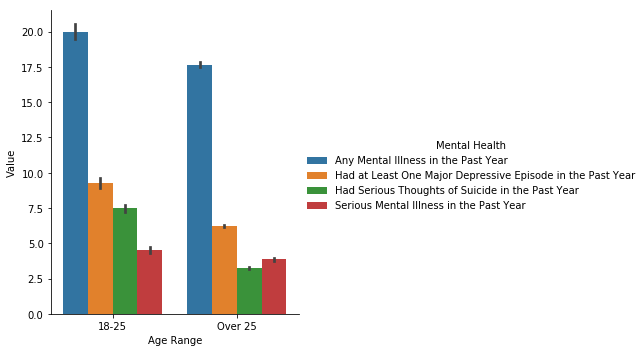

In [26]:
sns.catplot(x="Age Range", y="Value", hue="Mental Health", kind="bar", data=m_health);

It's interesting to see the breakdown of the prevalence of specific mental illnesses per age group. However, for the purposes of our credit card default model, we really only need the 'Any Mental Illness in the Past Year', since the specific type of mental illness is a little too much detail at this time.

In [27]:
#m_health.drop(m_health[m_health['Age Range'] == '12-17'].index, inplace = True) 
m_health.drop(m_health[m_health['Mental Health'] != 'Any Mental Illness in the Past Year'].index, inplace = True)
m_health.head()

,Region,Year,Age Range,Mental Health,Measure Type,Variable,Value
20,Connecticut,2010-2011,18-25,Any Mental Illness in the Past Year,Percent,Mental Health,18.05
28,Connecticut,2010-2011,Over 25,Any Mental Illness in the Past Year,Percent,Mental Health,16.36
36,Connecticut,2011-2012,18-25,Any Mental Illness in the Past Year,Percent,Mental Health,17.63
44,Connecticut,2011-2012,Over 25,Any Mental Illness in the Past Year,Percent,Mental Health,16.57
52,Connecticut,2012-2013,18-25,Any Mental Illness in the Past Year,Percent,Mental Health,18.30


We'll then utilize the mean of each age group (18-25, Over 25) since our datasets will be matched on the age column. The corresponding mean percent will then be populated when the datasets are concatenated.

In [28]:
young_mean = m_health[(m_health['Mental Health'] == 'Any Mental Illness in the Past Year') & 
                      (m_health['Age Range'] == '18-25') & (m_health['Year'] == '2010-2011')].mean()

print(young_mean)

Value    18.391667
dtype: float64


In [29]:
older_mean = m_health[(m_health['Mental Health'] == 'Any Mental Illness in the Past Year') & 
                      (m_health['Age Range'] == 'Over 25') & (m_health['Year'] == '2010-2011')].mean()

print(older_mean)

Value    17.598333
dtype: float64


In [30]:
m_health['Value'].unique()

array([18.05, 16.36, 17.63, 16.57, 18.3 , 17.1 , 18.01, 16.19, 21.34,
       16.78, 23.48, 17.11, 18.99, 18.34, 19.59, 18.15, 19.86, 18.35,
       20.45, 18.29, 21.43, 17.81, 22.25, 17.3 , 18.37, 17.65, 18.97,
       17.4 , 19.89, 17.84, 20.8 , 17.39, 22.  , 17.07, 22.58, 17.27,
       17.69, 17.77, 18.22, 18.08, 18.48, 17.97, 19.31, 17.57, 20.5 ,
       17.53, 18.33, 17.83, 19.06, 18.04, 19.5 , 18.36, 19.75, 20.89,
       17.52, 21.89, 17.44, 19.34, 17.72, 20.63, 18.17, 21.07, 18.58,
       20.7 , 18.46, 22.03, 17.51, 23.21, 17.67])

In [31]:
dummy = pd.get_dummies(m_health['Mental Health'], drop_first=True)
dummy2 = pd.get_dummies(m_health['Age Range'], drop_first=True)

m_health = pd.concat([m_health, dummy, dummy2], axis=1)
m_health.head()

,Region,Year,Age Range,Mental Health,Measure Type,Variable,Value,Over 25
20,Connecticut,2010-2011,18-25,Any Mental Illness in the Past Year,Percent,Mental Health,18.05,0
28,Connecticut,2010-2011,Over 25,Any Mental Illness in the Past Year,Percent,Mental Health,16.36,1
36,Connecticut,2011-2012,18-25,Any Mental Illness in the Past Year,Percent,Mental Health,17.63,0
44,Connecticut,2011-2012,Over 25,Any Mental Illness in the Past Year,Percent,Mental Health,16.57,1
52,Connecticut,2012-2013,18-25,Any Mental Illness in the Past Year,Percent,Mental Health,18.30,0


In [32]:
m_health.corr()['Value'].sort_values(ascending=False)

Value      1.000000
Over 25   -0.683287
Name: Value, dtype: float64

In [33]:
m_health['Value'].describe()

count    72.000000
mean     18.821528
std       1.717982
min      16.190000
25%      17.645000
50%      18.255000
75%      19.777500
max      23.480000
Name: Value, dtype: float64

In [34]:
health = m_health[['Mental Health', 'Value', 'Over 25']]

health.head()

,Mental Health,Value,Over 25
20,Any Mental Illness in the Past Year,18.05,0
28,Any Mental Illness in the Past Year,16.36,1
36,Any Mental Illness in the Past Year,17.63,0
44,Any Mental Illness in the Past Year,16.57,1
52,Any Mental Illness in the Past Year,18.30,0


In [35]:
def calculate_mental_health(row): 
    if row['age'] > 26:
        return older_mean
    else:
        return young_mean

credit['ment_health_percent'] = credit.apply(calculate_mental_health, axis=1)

In [36]:
credit.head()

,id,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,...,education_1,education_2,education_3,education_4,education_5,education_6,marriage_1,marriage_2,marriage_3,ment_health_percent
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,1,0,0,0,0,1,0,0,18.391667
1,2,120000,2,2,2,26,-1,2,0,0,...,0,1,0,0,0,0,0,1,0,18.391667
2,3,90000,2,2,2,34,0,0,0,0,...,0,1,0,0,0,0,0,1,0,17.598333
3,4,50000,2,2,1,37,0,0,0,0,...,0,1,0,0,0,0,1,0,0,17.598333
4,5,50000,1,2,1,57,-1,0,-1,0,...,0,1,0,0,0,0,1,0,0,17.598333


In [37]:
credit.corr()['default_target'].sort_values(ascending=False)

default_target    1.000000
pay_0_2           0.353881
pay_0             0.324794
pay_2_2           0.313191
pay_3_2           0.270885
pay_2             0.263551
pay_4_2           0.249674
pay_5_2           0.239308
pay_3             0.235253
pay_6_2           0.219068
pay_4             0.216614
pay_5             0.204149
pay_6             0.186866
pay_0_3           0.134656
pay_0_1           0.106690
pay_2_3           0.099842
pay_6_3           0.079513
pay_5_3           0.076993
pay_3_3           0.076549
pay_4_3           0.072986
pay_4_7           0.064301
pay_5_7           0.064301
pay_6_7           0.057111
pay_0_4           0.056219
pay_4_4           0.051532
pay_5_4           0.049273
pay_3_4           0.043438
pay_3_7           0.042926
pay_6_4           0.040097
pay_2_4           0.039351
                    ...   
bill_amt4        -0.010156
id               -0.013952
bill_amt3        -0.014076
bill_amt2        -0.014193
bill_amt1        -0.019644
marriage         -0.024339
e

After all that work, it seems the incidence of mental health is not very correlated to credit card default. It is interesting to note, that it is seems to be just as correlated as our 'age', and 'marriage' variables. Nevertheless, let's do some additional modeling with those variables added to see if we can create a better model.

In [38]:
# Y is the target variable
Y2 = credit['default_target']
# X is the feature set 
X2 = credit[['pay_0_2', 'pay_2_2', 'pay_3_2', 'pay_4_2', 'pay_0_0', 'marriage_2','ment_health_percent']]

# We create a LinearRegression model object
# from scikit-learn's linear_model module.
lrm2 = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm2.fit(X2, Y2)

# Inspect the results.
print('\nCoefficients: \n', lrm2.coef_)
print('\nIntercept: \n', lrm2.intercept_)


Coefficients: 
 [ 0.33746765  0.13203487  0.09683852  0.11359973 -0.06728347 -0.02444338
  0.0386657 ]

Intercept: 
 -0.4900090018154368


In [39]:
X2 = sm.add_constant(X2)

results = sm.OLS(Y2, X2).fit()

results.summary()

/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         default_target   R-squared:                       0.177
Model:                            OLS   Adj. R-squared:                  0.177
Method:                 Least Squares   F-statistic:                     922.7
Date:                Mon, 23 Sep 2019   Prob (F-statistic):               0.00
Time:                        12:24:40   Log-Likelihood:                -13262.
No. Observations:               30000   AIC:                         2.654e+04
Df Residuals:                   29992   BIC:                         2.661e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.4900      0.136     -3.613      0.000      -0.756      -0.224
pay_0_2                 0.3375      0.009     38.652      0.000       0.320       0.355
pay_2_2                 0.1320      0.008     15.689      0.000       0.116       0.149
pay_3_2                 0.0968      0.009     11.323      0.000       0.080       0.114
pay_4_2                 0.1136      0.009     13.257      0.000       0.097       0.130
pay_0_0                -0.0673      0.005    -14.021      0.000      -0.077      -0.058
marriage_2             -0.0244      0.005     -5.325      0.000      -0.033      -0.015
ment_health_percent     0.0387      0.008      5.019      0.000       0.024       0.054
==============================================================================
Omnibus:                     5173.491   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8264.020
Skew:                           1.235   Prob(JB):                         0.00
Kurtosis:                       3.716   Cond. No.                     1.11e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.11e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [40]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, Y2, test_size = 0.2, random_state = 465)

scaler = StandardScaler()
X_std2 = scaler.fit_transform(X2)

regr_cv2 = RidgeCV(alphas=[0.1, 1.0, 5, 10.0, 100, 500, 1000, 2000, 10**4, 10**6])
model_cv2 = regr_cv.fit(X_std2, Y2)
model_cv2.alpha_


100.0

In [41]:
ridgeregr2 = Ridge(alpha=100) 
ridgeregr2.fit(X_train2, y_train2)

# We are making predictions here
y_preds_train2 = ridgeregr2.predict(X_train2)
y_preds_test2 = ridgeregr2.predict(X_test2)

print("R-squared of the model on the training set is: {}".format(ridgeregr2.score(X_train2, y_train2)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridgeregr2.score(X_test2, y_test2)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test2, y_preds_test2)))
print("Mean squared error of the prediction is: {}".format(mse(y_test2, y_preds_test2)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test2, y_preds_test2)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test2 - y_preds_test2) / y_test2)) * 100))


R-squared of the model on the training set is: 0.17540094555548236
-----Test set statistics-----
R-squared of the model on the test set is: 0.18318410856702727
Mean absolute error of the prediction is: 0.2832318435452724
Mean squared error of the prediction is: 0.1402418204304349
Root mean squared error of the prediction is: 0.3744887453988903
Mean absolute percentage error of the prediction is: inf


In [42]:
 print(cross_val_score(ridgeregr2, X2, Y2, cv=10)) 

[0.13296083 0.14363396 0.16066475 0.13253142 0.17376826 0.23808049
 0.20653746 0.17336689 0.19565557 0.18412071]


Not surprisingly, our models were not improved. Since our model is really not performing very well, let's try some Logisitic Regression.

In [43]:
logreg = linear_model.LogisticRegression()
# Make predictions using the first set of variables and assign the AUC to auc_1
logreg.fit(X2, Y)
predictions_1 = logreg.predict_proba(X2)[:,1]
auc_1 = roc_auc_score(Y, predictions_1)

# Print auc_1 and auc_2
print(round(auc_1,2))


0.73


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [44]:
# Make predictions using the second set of variables and assign the AUC to auc_2
predictions_2 = logreg.predict_proba(X2)[:,1]
auc_2 = roc_auc_score(Y2, predictions_2)

print(round(auc_2,2))

0.73


In [45]:
# Assign the coefficients to a list coef
coef = logreg.coef_
for p,c in zip(X2,list(coef[0])):
    print(p + '\t' + str(c))

# Assign the intercept to the variable intercept
intercept = logreg.intercept_
print(intercept)

const	-2.137595675078195
pay_0_2	1.5373936450169203
pay_2_2	0.6137855170458594
pay_3_2	0.519713275496804
pay_4_2	0.614782512411288
pay_0_0	-0.5052979547150174
marriage_2	-0.15239968539560478
ment_health_percent	0.16104168867264124
[-2.13759568]


In [46]:
# Make a prediction for each observation in X2 and assign it to predictions
predictions = logreg.predict_proba(X2)
print(predictions)




[[0.30199562 0.69800438]
 [0.70098242 0.29901758]
 [0.89078879 0.10921121]
 ...
 [0.74532126 0.25467874]
 [0.80862896 0.19137104]
 [0.87505619 0.12494381]]


In [47]:
correlation = np.corrcoef(credit["ment_health_percent"], credit["default_target"])[0,1]
print(round(correlation,2))

0.03


In [48]:
correlation = np.corrcoef(credit["pay_0"], credit["default_target"])[0,1]
print(round(correlation,2))

0.32


Maybe it's better to approach this as a classification problem. WE are essentially trying to determine if someone will default or not default. It's possible that utilizing some gradient boosting might improve our model. Let's try an SGDClassifier first.

In [49]:
def gridsearch(model, params):
    gs = GridSearchCV(model, params, scoring='roc_auc', n_jobs=-1)
    gs.fit(X_train, y_train)
    print('Best params: ', gs.best_params_)
    print('Best auc on training set: ', gs.best_score_)
    print ('Best auc on test set: ', gs.score(X_test, y_test))
    return gs.predict(X_test), gs.decision_function(X_test)

In [50]:
def plot_confusion(prediction):
    conmat = np.array(confusion_matrix(y_test, prediction, labels=[1,0]))
    confusion = pd.DataFrame(conmat, index=['default', 'not default'], 
                             columns=['predicted default', 'predicted not default'])
    print(confusion)

In [51]:
def plot_roc(prob):
    y_score = prob
    fpr = dict()
    tpr = dict()
    roc_auc=dict()
    fpr[1], tpr[1], _ = roc_curve(y_test, y_score)
    roc_auc[1] = auc(fpr[1], tpr[1])

    plt.figure(figsize=[9,7])
    plt.plot(fpr[1], tpr[1], label='Roc curve (area=%0.2f)' %roc_auc[1], linewidth=4)
    plt.plot([1,0], [1,0], 'k--', linewidth=4)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('false positive rate', fontsize=18)
    plt.ylabel('true positive rate', fontsize=18)
    plt.title('ROC curve for credit default', fontsize=18)
    plt.legend(loc='lower right')
    plt.show()

In [52]:
sgd = SGDClassifier(loss='log', penalty='l1', learning_rate='optimal')

# use grid search to optimize parameters
sgd_params = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 5.0], 'class_weight': [None, 'balanced']}

sgd_pred, sgd_prob = gridsearch(sgd, sgd_params)

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best params:  {'alpha': 0.001, 'class_weight': 'balanced'}
Best auc on training set:  0.7304811229368009
Best auc on test set:  0.7309229846048162


In [53]:
# Check the accuracy score

sgd = SGDClassifier(loss='log', penalty='l1', learning_rate='optimal', alpha=0.001)
print('accuracy score on training set: ', cross_val_score(sgd, X_train, y_train, n_jobs=-1).mean())
print('accuracy score on testing set: ', accuracy_score(sgd_pred, y_test))

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


accuracy score on training set:  0.8111255032233151
accuracy score on testing set:  0.7885


In [54]:
# create classification report
print(classification_report(y_test, sgd_pred, target_names=['not default', 'default']))

              precision    recall  f1-score   support

 not default       0.86      0.86      0.86      4679
     default       0.52      0.52      0.52      1321

    accuracy                           0.79      6000
   macro avg       0.69      0.69      0.69      6000
weighted avg       0.79      0.79      0.79      6000



In [55]:
# create confusion matrix
plot_confusion(sgd_pred)

             predicted default  predicted not default
default                    687                    634
not default                635                   4044


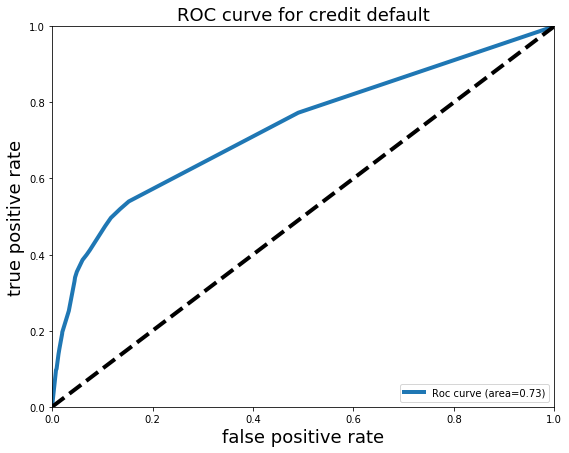

In [56]:
# plot roc curve and calculate auc
plot_roc(sgd_prob)

Next, we'll try a Decision Tree Regressor

Weak learner 0 R^2: -0.5325771758410447
Weak learner 20 R^2: -3.205685587759355e-05
Weak learner 40 R^2: -9.479405589374322e-07
Weak learner 60 R^2: -9.381272403352625e-08
Weak learner 80 R^2: -1.0281591356076092e-08
Weak learner 100 R^2: -9.670861889077287e-10


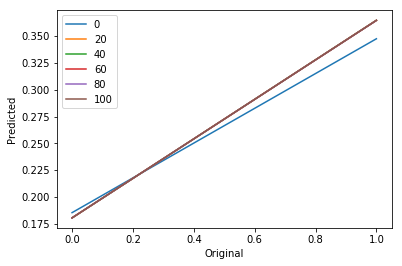

Overall R^2:
0.4291506633982896


In [57]:
# Iterate through decision trees, each time using the residuals
# from the previous tree as the inputs.
preds = pd.DataFrame()
labels = []
uniquex = credit['default_target'].unique()

for m in range(0, 101):
    
    # Initialize and fit the tree. Set the max depth to 2.
    decision_tree = tree.DecisionTreeRegressor(max_depth=2)
    decision_tree.fit(X,Y)
    
    # Get and store predicted values.
    pred = decision_tree.predict(X)
    preds['pred{}'.format(m)] = pred
    
    # Residuals.
    Y = Y - pred

    # Output every 20 iterations.
    if m % 20 == 0:
        print('Weak learner {} R^2: {}'.format(m, decision_tree.score(X, Y)))
        labels = labels + [m]
        bestpred = preds.sum(axis=1)
        plt.plot(uniquex, np.poly1d(np.polyfit(credit['default_target'], bestpred, 1))(uniquex))
       
plt.legend(labels)
plt.xlabel('Original')
plt.ylabel('Predicted')
plt.show()
predicted = preds.sum(axis=1)

print('Overall R^2:')
print(np.corrcoef(credit['default_target'], predicted)[0, 1])

In [58]:
from sklearn.ensemble import RandomForestRegressor

# Create the random forest model and fit to the training data
rfr = RandomForestRegressor(n_estimators=200)
rfr.fit(X_train, y_train)

# Look at the R^2 scores on train and test
print(rfr.score(X_train, y_train))
print(rfr.score(X_test, y_test))

0.1838482536213918
0.18808303234625645


Our Random Forest Regressor is just about as accurate as our other regression models. So, our last attempt will be a Decision Tree Classifier. Let's see how this performs.

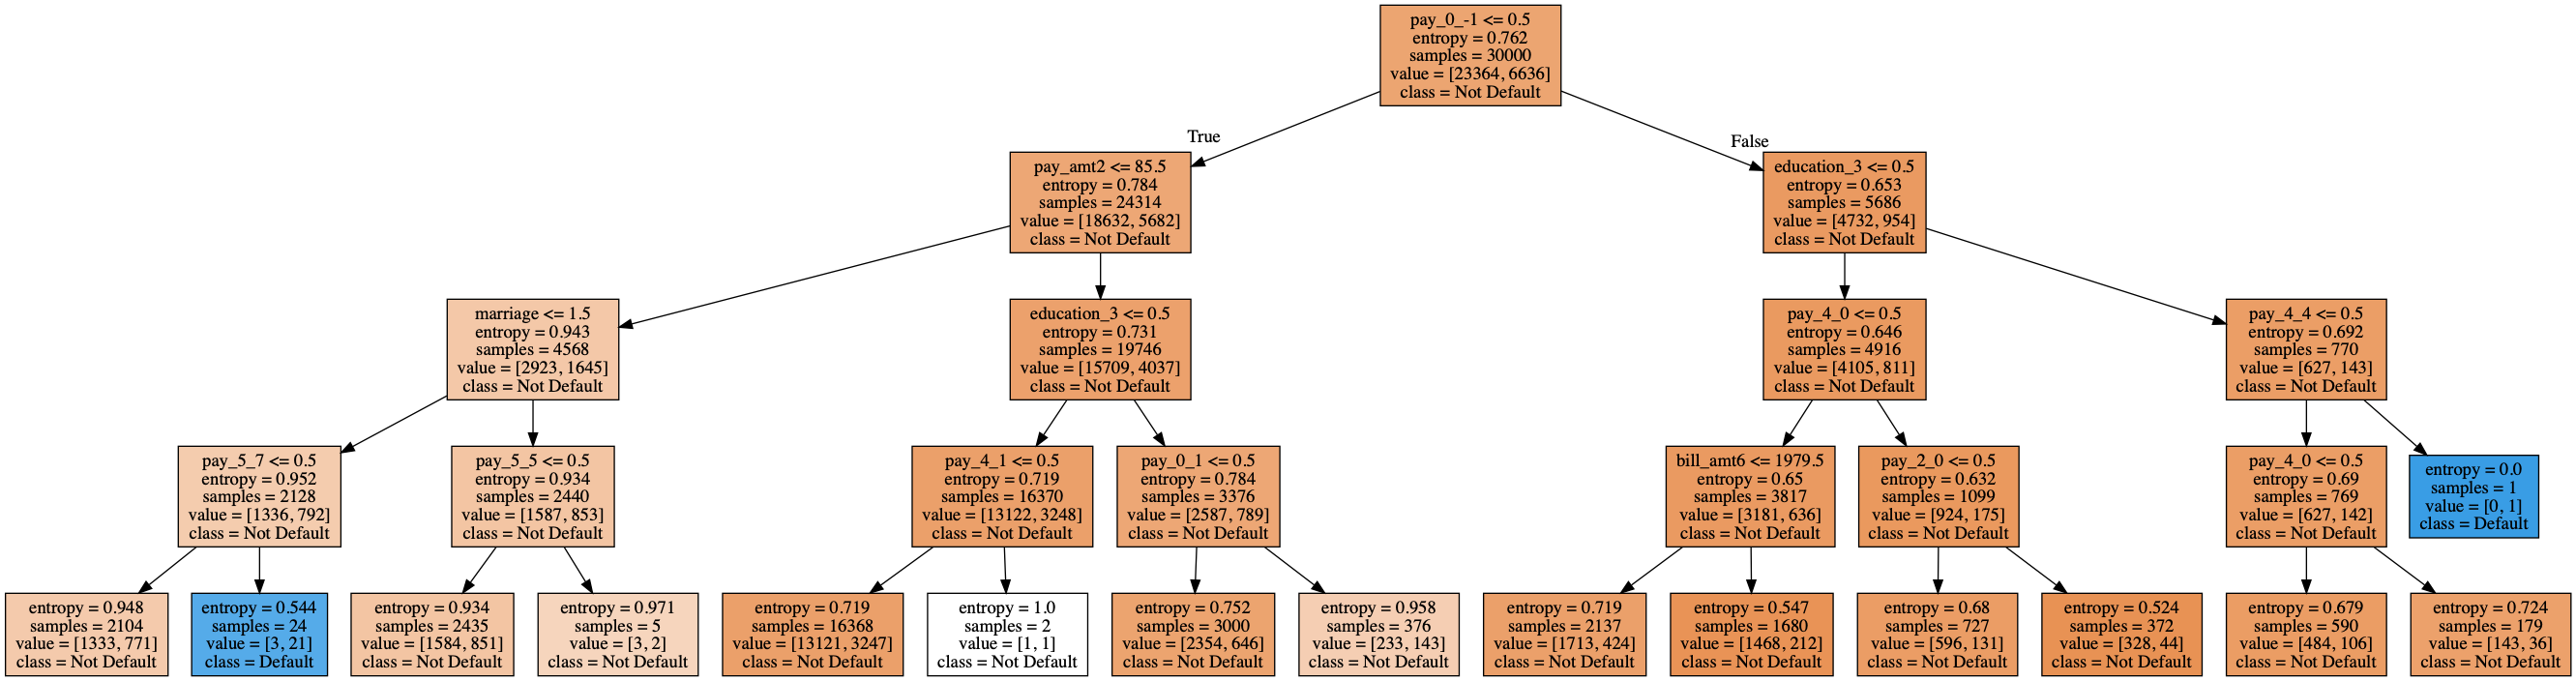

In [60]:
default = credit['default_target']

# Initialize and train our tree.
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=1,
    max_depth=4,
    random_state = 1337
)
decision_tree.fit(credit, default)

# Render our tree.
dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=credit.columns,
    class_names=['Not Default', 'Default'],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [61]:
 print(cross_val_score(decision_tree, X2, Y2, cv=10)) 

[0.79473509 0.79773409 0.80073309 0.79206931 0.79666667 0.806
 0.81927309 0.8156052  0.81127042 0.80926976]


This seems to be the winner! According to our cross_val_score our Classifier model is consistently predicting with about 80% accuracy.

## Summary

1) Overall, the likelihood of someone defaulting on their credit card is not great.
2) Payment history is the most important factor in determining if someone will default.
3) Mental health was not a significant factor in credit default in this case. Given that it is just as significant as many other factors such as education and gender, it may warrant further study.